In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
import scipy.io as sio
import sys
sys.path.append('../../ctrl_syn')
sys.path.append('..')
from torch_interpolations.torch_interpolations.multilinear import RegularGridInterpolator
from hji_utils import *

In [2]:

value = sio.loadmat('../../hji/stlhj/coverage_DoubleInt_test/value.mat');
deriv_value = sio.loadmat('../../hji/stlhj/coverage_DoubleInt_test/deriv_value.mat');
V = np.flip(value['data'], 5);
g = [s[0].flatten() for s in sio.loadmat('../../hji/stlhj/coverage_DoubleInt_test/grid.mat')['grid']];

values = torch.tensor(V).float()
dV = [torch.tensor(deriv_value['derivC'][i][0]).float() for i in range(5)];
points = [torch.from_numpy(g[i].flatten()).float() for i in range(4)] + [torch.from_numpy(np.arange(0,1.05, 0.05)).float()]
value_interp = RegularGridInterpolator(points, values)
deriv_interp = [RegularGridInterpolator(points, dV[i]) for i in range(5)]


In [2]:
kwargs = {'uMode': 'min', 'visualize': True}
projDim = [1,0,1,0]
data = V
tau = np.arange(0, 1.05, 0.05)
uMin = [-2,-2]
uMax = [2,2]
dynSys = DoubleIntegrator2D(uMin, uMax)
dynSys.x = np.ones(4) * 0.01

In [7]:
?np.flip

In [6]:
plt.Circle((0,0), radius= 5)


KeyboardInterrupt: 

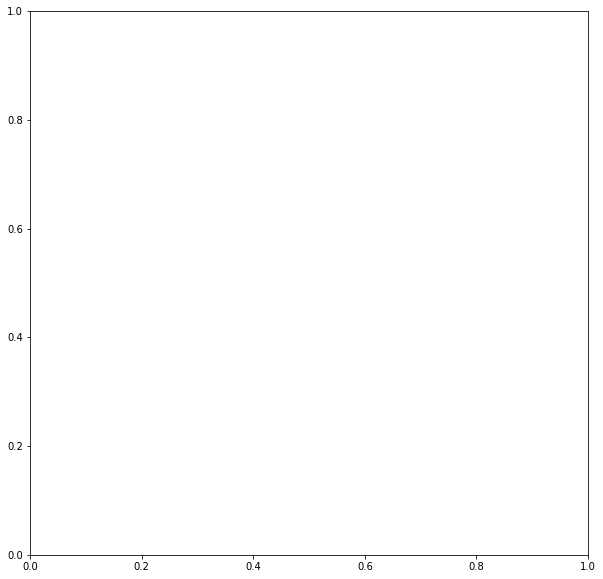

In [3]:
traj, traj_tau, values, tEarliest = computeOptTraj(g, data, tau, dynSys, projDim, uMode="min", visualize=True)

In [30]:
lower = 0
upper = len(tau) - 1
def find_earliest_BRS_ind(g, data, x, upper, lower):
    clns = [len(g)] + [i for i in range(len(g))]
    small = 1E-4
    x = np.array([0, 0, 0, 0])
    while upper > lower:
        tEarliest = int(np.ceil((upper + lower)/2))
        p = list(torch.tensor(x).split(1, dim=-1)) + [torch.tensor([tau[tEarliest]])]
        valueX = value_interp(p)
        if valueX < small:
            lower = tEarliest
        else:
            upper = tEarliest - 1

    return upper

In [6]:
p = list(torch.tensor(dynSys.x).split(1, dim=-1)) + [torch.tensor([tau[tEarliest]])]


In [9]:
dVt = compute_gradients(p, deriv_interp)    # [∇V , dV/dt]
dVt

[-0.06734481410834253,
 -0.009773078528750012,
 -0.02302372831524153,
 -0.0010603161512305944,
 -0.021485887510827067]

In [5]:
class DynSys(object):
    def __init__(self):
        self.x = None

    def dynamics(self, x, u, d, dt):
        raise 

    def OptCtrl(self, t, x, deriv, uMode):
        raise NotImplementedError

    def OptDstb(self, t, x, deriv, dMode):
        raise NotImplementedError

    def updateState(self, u, dtSmall, x):
        raise NotImplementedError



class DoubleIntegrator2D(DynSys):
    def __init__(self):
        super().__init__()
        self.A = np.eye(4)
        self.B = np.zeros([4,2])

    def dynamics(self, x, u, d, dt):
        if type(x) == list:
            x = np.array(x)
        if type(u) == list:
            u = np.array(u)
        # if type(d) == list:
        #     d = np.array(d)
        self.A[0,1] = dt
        self.A[2,3] = dt
        self.B[1,0] = dt
        self.B[3,1] = dt

        return self.A @ x + self.B @ u


In [7]:
dynSys = DoubleIntegrator2D()
dynSys.x = np.ones(4) * 0.01

In [49]:
dynSys.dynamics(dynSys.x, [1,1], None, 0.05)

array([0.0105, 0.06  , 0.0105, 0.06  ])

In [46]:
dynSys.A @ dynSys.x

array([0.0105, 0.01  , 0.0105, 0.01  ])

In [13]:
def compute_gradients(p, deriv_interp):
    return [di(p).squeeze().numpy().item() for di in deriv_interp]

In [15]:
dV = compute_gradients(p, deriv_interp)

In [17]:
if uMode == "max":
    (dV[1] >= 0) * self.uMax[0] + (dV[1] < 0) * self.uMin[0]
    (dV[3] >= 0) * self.uMax[1] + (dV[3] < 0) * self.uMin[1]
elif uMode == "min":
    (dV[1] <= 0) * self.uMax[0] + (dV[1] > 0) * self.uMin[0]
    (dV[3] <= 0) * self.uMax[1] + (dV[3] > 0) * self.uMin[1]

-0.009773078528750012

In [188]:
np.stack(traj)[:,0]

array([0.01, 0.01])

poop
In [1]: exit



ValueError: only one element tensors can be converted to Python scalars

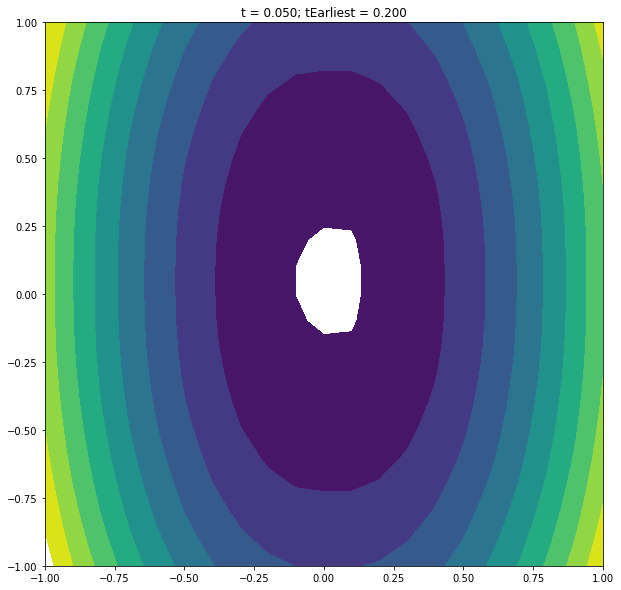

In [4]:


# def computeOptTraj(g, data, tau, dynSyS, **kwargs):
# Default parameters
uMode = 'min';
visualize = False;
subSamples = 4;
keys = kwargs.keys()

if 'uMode' in keys:
    uMode = kwargs['uMode']


# Visualization
if ('visualize' in keys) & (kwargs["visualize"] == True):
    visualize = kwargs['visualize']

if type(projDim) == list:
    projDim = np.array(projDim)

showDims = np.where(projDim)[0]
hideDims = np.where(1 - projDim)[0];

if 'fig' in keys:
    f, ax = kwargs['fig']
else:
    f, ax = plt.subplots(figsize=(10,10))


if 'subSamples' in keys:
    subSamples = kwargs['subSamples']

clns = [len(g)] + [i for i in range(len(g))]


if any(np.diff(tau)) < 0:
    raise Exception('Time stamps must be in ascending order!')



# Time parameters
it = 1;
tauLength = len(tau);
dtSmall = (tau[1] - tau[0]) / subSamples

# Initialize trajectory
traj = []
values = []
tEarliestList = []
traj.append(dynSys.x);
tEarliest = 0;

while it <= tauLength:
    # Determine the earliest time that the current state is in the reachable set
    # Binary search
    upper = tauLength - 1;
    lower = tEarliest;
#     tEarliest = find_earliest_BRS_ind(g, data, dynSys.x, upper, lower);
    tEarliest = 4
    tEarliestList.append(tEarliest)
    # BRS at current time
    BRS_at_t = np.transpose(data, clns)[tEarliest]
    p = list(torch.tensor(dynSys.x).split(1, dim=-1)) + [torch.tensor([tau[tEarliest]])]
    values.append(value_interp(p).squeeze().numpy().item())
    # Visualize BRS corresponding to current trajectory point
    if visualize:
        traj_flatten = np.stack(traj)
        ax.plot(traj_flatten[1:it, showDims[0]], traj_flatten[1:it, showDims[1]], 'k')
        g2D, data2D = proj(g, traj[-1], value_interp, showDims, hideDims, tau, tEarliest)
        ax.contourf(*g2D, data2D, np.arange(0,5,0.5))
        ax.set_title('t = %.3f; tEarliest = %.3f'%(tau[it], tau[tEarliest]))

    if 'fig_filename' in keys:
      f.savefig(kwargs['fig_filename'] + "_{:02d}.png".format(it))



    if tEarliest == tauLength:
    # Trajectory has entered the target
        break

    # Update trajectory
    dVt = compute_gradients(p, deriv_interp)    # [∇V , dV/dt]
    for j in range(subSamples):
        u = dynSys.optCtrl(tau[tEarliest], dynSys.x, dVt, uMode)
        dynSys.updateState(u, dtSmall, dynSys.x)

    # Record new point on nominal trajectory
    it = it + 1;
    traj.append(dynSys.x)

# Delete unused indices
traj_tau = tau[:it];

#     return traj, traj_tau, values, tEarliest